# Retrieving and Graphing SNP Minor Allele Frequencies

1. Using Entrez Programming Utilities (E-utilities) to

   1. Search for genes of interest
   2. Search for a filtered set of SNPs on specific genes
   3. Retrieve MAF data for specific SNPs

2. Using `matplotlib` Python module to graph MAF from available studies

---

#### Prepare environment: import useful modules, define constants:

In [1]:
import requests
import xml.etree.ElementTree as xtree
import ipywidgets as wgt
from urllib.parse import quote
import re

# When set to True, produce additional diagnostic output
verbose = False

# Base url for E-utilities
eutils_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils'

#### Create a text area for entering gene search terms; use "acmg" as an example:

In [2]:
search_term_input1 = wgt.Textarea(
    value='acmg',
    placeholder='Gene search term',
    description='Enter a gene search term:',
    style={'description_width': 'initial'},
    disabled=False
)

display( search_term_input1 )

Textarea(value='acmg', description='Enter a gene search term:', placeholder='Gene search term', style=Descript…

#### Get the gene search term, use it to search the NCBI Gene database with eSearch:

In [3]:
term1 = quote( search_term_input1.value )
srch1 = requests.get( '{}/esearch.fcgi?db=gene&term={}&usehistory=y'.format( eutils_url, term1 ) )

# Optional
if verbose:
    print( srch1.text )

#### Parse the eSearch response to get the number of genes found and the location of search results:

In [4]:
xr1 = xtree.fromstring( srch1.text )
web_env1 = xr1.find( './WebEnv' ).text
qry_key1 = xr1.find( './QueryKey' ).text
count1 = xr1.find( './Count' ).text
print( 'Number of genes found: {}'.format( count1 ) )

# Optional
if verbose:
    print( 'WebEnv:   {}'.format( web_env1 ) )
    print( 'QueryKey: {}'.format( qry_key1 ) )


Number of genes found: 60


#### Using eSummary get docsums for the genes in the result set, parse the docsums for gene names, descriptions, and UIDs:

In [5]:
# Get the first 500 gene docsums
sumr1 = requests.get( '{}/esummary.fcgi?db=gene&query_key={}&WebEnv={}&retmax=500'.format( eutils_url, qry_key1, web_env1 ) )
xds1 = xtree.fromstring( sumr1.text ).findall( './/DocumentSummary' )

# Optional
if verbose:
    print( 'Gene DocSums fetched: {}'.format( len( xds1 ) ) )

# Prepare a list of tuples with gene names+descriptions and UIDs for next step
genes = list()
for ds in xds1:
    name_descr = '{} : {}'.format( ds.find( 'Name' ).text, ds.find( 'Description' ).text )
    uid = ds.get( 'uid' )
    genes.append( ( name_descr, uid ) )

#### Create a drop-down selector with names and descriptions of the retrieved genes:

In [6]:
gene_sel = wgt.Dropdown(
    options=genes,
    description='Select a gene:',
    style={'description_width': 'initial'},
    layout=wgt.Layout( width='50%' ),
    disabled=False
)

display( gene_sel )

Dropdown(description='Select a gene:', layout=Layout(width='50%'), options=(('TP53 : tumor protein p53', '7157…

#### Create a text area for entering SNP search terms, using the selected Gene ID from above as one of the filters:

As an example, the SNP search string is preset to `(("by frequency"[Validation Status] AND "snp clinvar"[Filter]) AND <UID>[LocusLink ID]) AND 1000genomes[Submitter Handle]`, where `<UID>` is the Gene ID of the selected gene. The preset search terms specify a selection of SNP validated by frequency data, having been reported by the 1000Genomes project, having some defined clinical significance, and linked to the selected gene.

In [7]:
# Optional
if verbose:
    print( 'Selected Gene ID: {}'.format( gene_sel.value ) )

search_term_input2 = wgt.Textarea(
    value='(("by frequency"[Validation Status] AND "snp clinvar"[Filter]) AND {}[LocusLink ID]) AND 1000genomes[Submitter Handle]'.format( gene_sel.value ),
    placeholder='SNP search term',
    description='Enter SNP search terms:',
    style={'description_width': 'initial'},
    layout=wgt.Layout( width='60%' ),
    disabled=False
)

display( search_term_input2 )

Textarea(value='(("by frequency"[Validation Status] AND "snp clinvar"[Filter]) AND 7157[LocusLink ID]) AND 100…

#### Get the SNP search terms, use them to search the NCBI dbSNP database with eSearch:

In [8]:
term2 = quote( search_term_input2.value )
srch2 = requests.get( '{}/esearch.fcgi?db=snp&term={}&usehistory=y'.format( eutils_url, term2 ) )

# Optional
if verbose:
    print( srch2.text )

#### Parse the eSearch response to get the number of SNPs found and the location of search results:

In [9]:
xr2 = xtree.fromstring( srch2.text )
web_env2 = xr2.find( './WebEnv' ).text
qry_key2 = xr2.find( './QueryKey' ).text
count2 = xr2.find( './Count' ).text
print( 'Number of SNPs found: {}'.format( count2 ) )

# Optional
if verbose:
    print( 'WebEnv:   {}'.format( web_env2 ) )
    print( 'QueryKey: {}'.format( qry_key2 ) )

Number of SNPs found: 87


#### Using eSummary get docsums for the SNPs in the result set, parse the docsums for RSIDs:

In [10]:
# Get the first 500 SNP docsums
sumr2 = requests.get( '{}/esummary.fcgi?db=snp&query_key={}&WebEnv={}&retmax=500'.format( eutils_url, qry_key2, web_env2 ) )
xds2 = xtree.fromstring( sumr2.text ).findall( './/DocumentSummary' )

# Optional
if verbose:
    print( 'SNP DocSums fetched: {}'.format( len( xds2 ) ) )

snps = list()
snp_dict = dict()
for ds in xds2:
    rsid = ds.get( 'uid' )
    snps.append( ( 'rs'+rsid, rsid ) )
    snp_dict[rsid] = ds

#### Create a drop-down RSID selector: 

In [11]:
snp_sel = wgt.Dropdown(
    options=snps,
    description='Select a SNP:',
    style={'description_width': 'initial'},
    disabled=False
)

display( snp_sel )

Dropdown(description='Select a SNP:', options=(('rs1555523911', '1555523911'), ('rs576532147', '576532147'), (…

#### Parse the selected SNP's docsum to get its global MAF data:

In [12]:
xrs = snp_dict[snp_sel.value]
mafs = xrs.findall( './GLOBAL_MAFS/MAF' )
rsid = xrs.get( 'uid' )

# Optional
if verbose:
    print( 'Selected RSID: {}'.format( rsid ) )
    print( 'Number of freq studies: {}'.format( len( mafs ) ) )

studies = list()
freqs = list()
for xmaf in mafs:
    study = xmaf.find( 'STUDY' ).text
    freq = xmaf.find( 'FREQ' ).text
    allele, maf, ac = re.split( '=|/', freq )
    studies.append( study )
    freqs.append( float( maf ) )

#### Use `matplotlib` module to plot the global MAF data for the selected SNP:

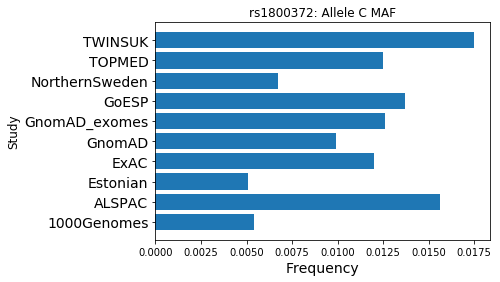

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

ypos = list( range( len( studies ) ) )
plt.barh( ypos, freqs )
plt.xlabel( 'Frequency', fontsize=14 )
plt.ylabel( 'Study', fontsize=12 )
plt.yticks( ypos, studies, fontsize=14 )
plt.title( 'rs{}: Allele {} MAF'.format( rsid, allele ) )
plt.show()